In [1]:
import uproot
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb


import warnings
warnings.filterwarnings("ignore")

/home/anson/.local/lib/python3.10/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


## Theoretical $q^2$

In [2]:
def dGammaJpsimu(q2):
    return 6.79842*10**(-7) * (0. + (1 + 0.0055125/q2) * ((4.31066 * np.exp(0.038 * q2 + 0.0015 * q2**2) - 0.0448191 * np.exp(0.065 * q2 + 0.0015* q2**2)*np.sqrt((10.106 - q2) * (87.8156 - q2)))**2 + \
            (4.31066 *np.exp(0.038 *q2 + 0.0015 *q2**2) + 0.0448191 *np.exp(0.065* q2 + 0.0015 *q2**2)*np.sqrt((10.106 - q2)* (87.8156 - q2)))**2 \
            + (2.29039* (0.007288 *np.exp(0.064 * q2 + 0.0041* q2**2)* (10.106 - q2)* (87.8156 - q2) + 0.46 *np.exp(0.038 *q2 + 0.0015 *q2**2) *(-29.7904 + q2))**2)/q2) + \
            (0.0057567 *np.exp(0.094 *q2 + 0.0034 *q2**2) *(10.106 - q2) *(87.8156 - q2))/q2**2)*(1 - 0.011025/q2)**2 *np.sqrt((10.106 - q2) *(87.8156 - q2))* q2


def dGammaJpsitau(q2):
    return 6.79842*10**(-7) * (0. + (1 + 1.58064/q2) * ((4.31066 *np.exp(0.038 *q2 + 0.0015* q2**2) - 0.0448191 *np.exp(0.065* q2 + 0.0015 *q2**2)* np.sqrt((10.106 - q2) *(87.8156 - q2)))**2 +\
            (4.31066 *np.exp(0.038 *q2 + 0.0015 *q2**2) +0.0448191 *np.exp(0.065* q2 + 0.0015 *q2**2)*np.sqrt((10.106 - q2)* (87.8156 - q2)))**2 \
            + (2.29039* (0.007288 *np.exp(0.064 *q2 + 0.0041 *q2**2)* (10.106 - q2)* (87.8156 - q2) + 0.46*np.exp(0.038 *q2 + 0.0015 *q2**2) *(-29.7904 + q2))**2)/q2) + \
            (1.65066 *np.exp(0.094* q2 + 0.0034 *q2**2)* (10.106 - q2) *(87.8156 - q2))/q2**2)* (1 - 3.16128/q2)**2 *np.sqrt((10.106 - q2) *(87.8156 - q2))* q2

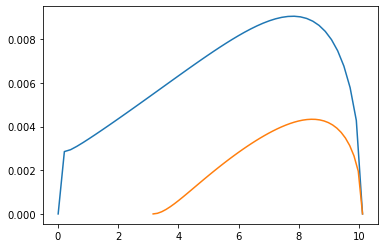

In [3]:
q2_mu = np.linspace(0.105**2, 10.106)
q2_tau = np.linspace(1.778**2, 10.106)

dGmu = dGammaJpsimu(q2_mu)
dGtau = dGammaJpsitau(q2_tau)

plt.plot(q2_mu, dGmu)
plt.plot(q2_tau, dGtau)

## Loading Data

In [4]:
epsilon_pimu = 1/100

# No veto

modes_dt = {0: {'mode': './features/IDEA_card_JpsiTauNu_10Noise_NoVeto.root', 'yields': 3.98e3}, 
            1: {'mode': './features/IDEA_card_JpsiTauNu_10Noise_NoVeto.root', 'yields': 1.08e5},
            2: {'mode': './features/RJpsiInclusive_10Noise_NoVeto.root', 'yields': 3.99e3},
            3: {'mode': './features/RJpsiCombCascade_10Noise_NoVeto.root', 'yields': 8.14e4},
            4: {'mode': './features/RJpsiMisID_10Noise_NoVeto.root', 'yields': epsilon_pimu*1.11e8}
           }


In [5]:
def load_train_test(modes_dt, size=0.5):
    np.random.seed(9)
    df_train = pd.DataFrame()
    df_test = pd.DataFrame()
    num_lt = []
    
    # loop over different modes
    for i, (k, v) in enumerate(modes_dt.items()):
        print('\rReading:', i)
        file = uproot.open(v['mode'])
#         df_i = file['t'].pandas.df()
        df_i = pd.DataFrame(np.array(file['t']['features'].array()))
        
        # shuffle the index for training and testing sets
        idx = df_i.index.tolist()
        np.random.shuffle(idx)
#         print(len(idx))
        idx = idx[:100000]    # if too much data
        num_lt.append(len(idx))    

        df_i['target'] = i    # add the target label
        df_i['weight'] = v['yields']/len(idx)
        print(df_i['weight'][0])
        
        # cut according to the fraction
        cut = int(np.ceil(len(idx) * size))
        df_train_i = df_i.loc[idx[:cut]]
        df_test_i = df_i.loc[idx[cut:]]
        
        # Put to the global dataframs
        df_train = pd.concat([df_train, df_train_i])
        df_test = pd.concat([df_test, df_test_i])
    
    df_train.reset_index(drop=True, inplace=True)
    df_test.reset_index(drop=True, inplace=True)
    
    print('train size: {} ({:.2f}%); test size: {} ({:.2f}%)'.format(len(df_train), 100*len(df_train)/(len(df_train)+len(df_test)), len(df_test), 100*len(df_test)/(len(df_train)+len(df_test))))
    print('data points per mode: ',num_lt)
    return df_train, df_test

    

In [6]:
tr_te_split = 0.5
df_train, df_test = load_train_test(modes_dt, tr_te_split)
# make a copy
df_train_o, df_test_o = df_train.copy(), df_test.copy()

Reading: 0
1.8485833720390152
Reading: 1
50.162563864375294
Reading: 2
45.86206896551724
Reading: 3
45.73033707865169
Reading: 4
11.1
train size: 53088 (50.00%); test size: 53085 (50.00%)
data points per mode:  [2153, 2153, 87, 1780, 100000]


In [7]:
def relabel(x):
    if x == 0:    # tau
        return 0
    elif x == 1:    # mu
        return 1
    else:    # other bkg
        return 2

In [8]:
# relabel the, all bkg become one label
df_train['target'] = df_train['target'].apply(relabel)
df_test['target'] = df_test['target'].apply(relabel)

In [9]:
df_train.columns

Index(['iEvt', 'q2', 'miss2', 'pB', 'EB', 'pHc', 'EHc', 'pMu', 'EMu',
       'sMinMuBVert', 'sMinMuHcVert', 'sMinMuTr', 'sMinHcTr', 'sPVHc', 'mHcMu',
       'pPerp', 'mCorr', 'D0Max', 'DzMax', 'D0Sum', 'DzSum', 'ENeutral03',
       'ENeutral06', 'ENeutral03Hadron', 'ENeutral06Hadron',
       'ENeutral03Photon', 'ENeutral06Photon', 'ECharge03', 'ECharge06',
       'ECharge03PV', 'ECharge06PV', 'ECharge03DV', 'ECharge06DV', 'mK0SHcMu',
       'pK0S', 'q2True', 'miss2True', 'EBTrue', 'pBTrue', 'sMinMuHcVertTrue',
       'target', 'weight', 'pPerpHc'],
      dtype='object')

In [10]:
# features = ['q2', 'miss2', 
#             'pB', 'EB', 
#             'pHc', 'EHc', 
#             'pMu', 'EMu',
#             'sMinMuHcVert', 'sMinMuTr', 'sMinHcTr', 'sPVHc', 
#             'mHcMu',
#             'pPerp', 'mCorr', 
#             'D0Max', 'DzMax', 'D0Sum', 'DzSum', 
#             'ENeutral03','ENeutral06', 
#             'ENeutral03Hadron', 'ENeutral06Hadron',
#             'ENeutral03Photon', 'ENeutral06Photon', 
#             'ECharge03', 'ECharge06',
#             'ECharge03PV', 'ECharge06PV', 
#             'ECharge03DV', 'ECharge06DV', 
#             'mK0SHcMu', 'pK0S'
#            ]

features = ['q2', 'miss2', 
            'pB', 'EB', 
            'pHc', 'EHc', 
            'pMu', 'EMu',
            'sMinMuHcVert', 'sMinMuTr', 'sMinHcTr', 'sPVHc', 
            'mHcMu',
            'pPerp', 'mCorr', 
            'D0Max', 'DzMax', 'D0Sum', 'DzSum', 
            'ENeutral03','ENeutral06', 
            'ENeutral03Hadron', 'ENeutral06Hadron',
            'ENeutral03Photon', 'ENeutral06Photon', 
            'ECharge03', 'ECharge06',
            'ECharge03PV', 'ECharge06PV', 
            'ECharge03DV', 'ECharge06DV'
           ]

In [11]:
df_train[features] = df_train[features].replace([99999, -np.inf, np.inf], np.nan)
df_test[features] = df_test[features].replace([99999, -np.inf, np.inf], np.nan)

## Reweight by $q^2
$

In [12]:
# replace some values that have q2 larger than the max, by the max
# df_train_o.loc[(df_train_o['q2True']>=11) & ((df_train_o.target==0) | (df_train_o.target==1)), 'q2True'] = 10.9
# df_train.loc[(df_train['q2True']>=11) & ((df_train.target==0) | (df_train.target==1)), 'q2True'] = 10.9
# df_test.loc[(df_test['q2True']>=11) & ((df_test.target==0) | (df_test.target==1)), 'q2True'] = 10.9

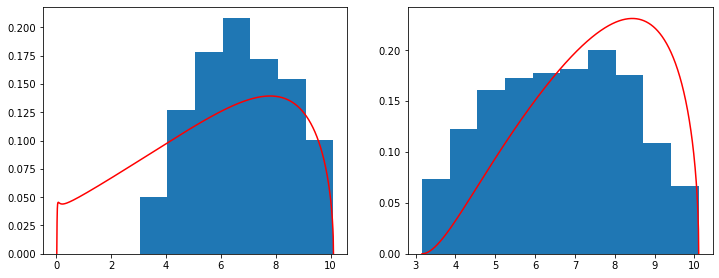

In [13]:
bins = 10

plt.figure(figsize=(12, 10))

# plot for mu
ax1 = plt.subplot(221)
range_mu = [0.105**2, 10.106]
ax1.hist(df_train_o[df_train_o.target==1]['q2True'], bins=bins, density=True, range=range_mu);
q2_mu = np.linspace(range_mu[0], range_mu[1], 1000, endpoint=True)
dGmu = dGammaJpsimu(q2_mu)
ax1.plot(q2_mu, dGmu/np.trapz(dGmu, x=q2_mu), color='red', label='theoretical')

# plot for tau
ax2 = plt.subplot(222)
range_tau = [1.778**2, 10.106]
ax2.hist(df_train_o[df_train_o.target==0]['q2True'], bins=bins, density=True, range=range_tau);
q2_tau = np.linspace(range_tau[0], range_tau[1], 1000, endpoint=True)
dGtau = dGammaJpsitau(q2_tau)
ax2.plot(q2_tau, dGtau/np.trapz(dGtau, x=q2_tau), color='red', label='theoretical')

In [14]:
# reweight according to q^2
def find_m_rw(dGamma, df_train, target, range_, bin_num=10):
    # get the truth q2 array
    q2 = df_train[df_train.target==target]['q2True'].values    

    # Simulated bins
    hist, bins = np.histogram(a=q2, bins=bin_num, density=True, range=range_)
    width = np.diff(bins)
    center = (bins[:-1] + bins[1:]) / 2

    # Theoretical bins
    th_w = []
    for i in range(bin_num):
        dx = -(bins[i] - bins[i+1])/10
        x = np.linspace(bins[i], bins[i+1], 1000)
        y = dGamma(q2=x)
        th_w.append(np.trapz(y, dx=dx))    # Find area under curve
    # normalize
    th_w = th_w / sum(th_w) / width

    # reweighting
    m_rw = th_w / hist
    m_rw[np.isinf(m_rw)] = 0
    
    # return the values of each bin, and the bin bounds
    return m_rw, bins





# add the reweighting column to th dataframe
def add_m_rw(target, m_rw, bins, df):
    for i in range(len(bins)-1):
        df.loc[(df['target']==target) & (df['q2True']>=bins[i]) & (df['q2True']<bins[i+1]), 'm_rw'] = m_rw[i]
    
#     print(df.loc[df['target']==target, 'weight'].sum())
#     df.loc[df.target==target, 'm_rw'] = df.loc[df.target==target, 'm_rw']/(df.loc[df.target==target, 'm_rw'].sum())
    df.loc[df['target']==target, 'reweight'] = df.loc[df['target']==target, 'weight'] * df.loc[df.target==target, 'm_rw']
    df = df.drop(columns = ['m_rw'])
    
#     print(df.loc[df.target==target, 'reweight'].sum())
#     print()
    return df

In [15]:
# getting the weightings, and the bin bounds
m_rw_tau, bins_tau = find_m_rw(dGammaJpsitau, df_train_o, target=0, range_=range_tau)
m_rw_mu, bins_mu = find_m_rw(dGammaJpsimu, df_train_o, target=1, range_=range_mu)

# duplicate the column for inputting to the function to get the reweight column
df_train_o['reweight'] = df_train_o['weight']
df_train['reweight'] = df_train['weight']
df_test['reweight'] = df_test['weight']

df_train_o = add_m_rw(target=0, m_rw=m_rw_tau, bins=bins_tau, df=df_train_o)
df_train_o = add_m_rw(target=1, m_rw=m_rw_mu, bins=bins_mu, df=df_train_o)

df_train = add_m_rw(target=0, m_rw=m_rw_tau, bins=bins_tau, df=df_train)
df_train = add_m_rw(target=1, m_rw=m_rw_mu, bins=bins_mu, df=df_train)

df_test = add_m_rw(target=0, m_rw=m_rw_tau, bins=bins_tau, df=df_test)
df_test = add_m_rw(target=1, m_rw=m_rw_mu, bins=bins_mu, df=df_test)


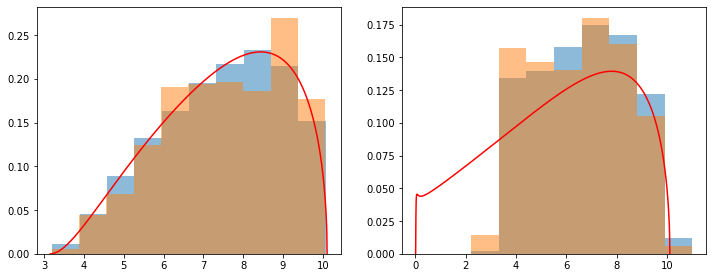

In [16]:
bins = 10

plt.figure(figsize=(12, 10))

# reweighted plot for tau, in testing 
ax1 = plt.subplot(221)
ax1.hist(df_train[df_train.target==0]['q2True'], bins=10, weights=df_train[df_train.target==0]['reweight'], density=True, alpha=0.5);
ax1.hist(df_test[df_test.target==0]['q2True'], bins=10, weights=df_test[df_test.target==0]['reweight'], density=True, alpha=0.5);
ax1.plot(q2_tau, dGtau/np.trapz(dGtau, x=q2_tau), color='red', label='theoretical')

# reweighted plot for mu, in testing 
ax2 = plt.subplot(222)
ax2.hist(df_train[df_train.target==1]['q2True'], bins=10, weights=df_train[df_train.target==1]['reweight'], density=True, alpha=0.5, range=[.105**2 ,11]);
ax2.hist(df_test[df_test.target==1]['q2True'], bins=10, weights=df_test[df_test.target==1]['reweight'], density=True, alpha=0.5, range=[.105**2 ,11]);
ax2.plot(q2_mu, dGmu/np.trapz(dGmu, x=q2_mu), color='red', label='theoretical')

## Saving Plots

In [17]:
df_plot = df_test

In [20]:
# f = plt.figure(figsize=(8,6))
# ax1 = plt.subplot(111)
# range_=[0,50]

# ax1.hist(df_plot[(df_plot.target==0)]['EB'], weights=df_plot[df_plot.target==0]['reweight'], bins=20, range=range_, density=True, histtype='step', lw=3, label=r'$B_c^+\to J/\psi \tau^+\nu$', alpha=0.5, color='C0');
# ax1.hist(df_plot[(df_plot.target==1)]['EB'], weights=df_plot[df_plot.target==1]['reweight'], bins=20, range=range_, density=True, histtype='step', lw=3, label=r'$B_c^+\to J/\psi \mu^+\nu$', alpha=0.5, color='C1');
# ax1.hist(df_plot[(df_plot.target!=0)&(df_plot.target!=1)]['EB'], weights=df_plot[(df_plot.target!=0)&(df_plot.target!=1)]['reweight'], bins=20, range=range_, density=True, histtype='step', lw=3, label=r'Bkg.', alpha=0.5, color='C2');

# ax1.legend(loc=2, fontsize=20)
# ax1.hist(df_plot[(df_plot.target==0)]['EBTrue'], weights=df_plot[df_plot.target==0]['reweight'], bins=20, range=range_, density=True, histtype='step', lw=2, label=r'true $\Lambda_b^0\to \Lambda_c^- \tau^+\nu$', alpha=0.5, color='C0', linestyle='--');
# ax1.hist(df_plot[(df_plot.target==1)]['EBTrue'], weights=df_plot[df_plot.target==1]['reweight'], bins=20, range=range_, density=True, histtype='step', lw=2, label=r'true $\Lambda_b^0\to \Lambda_c^- \mu^+\nu$', alpha=0.5, color='C1', linestyle='--');

# ax1.set_ylabel('Normlized distribution', fontsize=20)
# ax1.set_xlabel(r'$E_{B_c^+}$ [GeV]', fontsize=20)
# ax1.set_yticks([])



X_mea0 = df_plot[(df_plot.target==0)]['EB']
X_mea1 = df_plot[(df_plot.target==1)]['EB']
X_tru0 = df_plot[(df_plot.target==0)]['EBTrue']
X_tru1 = df_plot[(df_plot.target==1)]['EBTrue']

X0 = X_mea0 - X_tru0
X1 = X_mea1 - X_tru1

W0 = df_plot[(df_plot.target==0)]['reweight']
W1 = df_plot[(df_plot.target==1)]['reweight']

X_Wmean0 = sum(X0 * W0) / sum(W0)
X_Wmean1 = sum(X1 * W1) / sum(W1)

print("E_B")
print("error for tau mode:  {:.2f}".format((sum((X0 - X_Wmean0)**2 * W0) / (sum(W0)*(len(W0)-1)/len(W0)))**0.5))
print("error for mu mode: {:.2f}".format((sum((X1 - X_Wmean1)**2 * W1) / (sum(W1)*(len(W1)-1)/len(W1)))**0.5))


E_B
error for tau mode:  1.25
error for mu mode: 1.29


In [21]:
# f = plt.figure(figsize=(8,6))
# ax1 = plt.subplot(111)
# range_=[-10,13]

# ax1.hist(df_plot[(df_plot.target==0)]['q2'], weights=df_plot[df_plot.target==0]['reweight'], bins=20, range=range_, density=True, histtype='step', lw=3, label=r'$B_c^+\to J/\psi \tau^+\nu$', alpha=0.5, color='C0');
# ax1.hist(df_plot[(df_plot.target==1)]['q2'], weights=df_plot[df_plot.target==1]['reweight'], bins=20, range=range_, density=True, histtype='step', lw=3, label=r'$B_c^+\to J/\psi \mu^+\nu$', alpha=0.5, color='C1');
# ax1.hist(df_plot[(df_plot.target!=0)&(df_plot.target!=1)]['q2'], weights=df_plot[(df_plot.target!=0)&(df_plot.target!=1)]['reweight'], bins=20, range=range_, density=True, histtype='step', lw=3, label=r'Bkg.', alpha=0.5, color='C2');

# ax1.legend(loc=2, fontsize=20)
# ax1.hist(df_plot[(df_plot.target==0)]['q2True'], weights=df_plot[df_plot.target==0]['reweight'], bins=20, range=range_, density=True, histtype='step', lw=2, label=r'$\Lambda_b^0\to \Lambda_c^- \tau^+\nu$', alpha=0.5, color='C0', linestyle='--');
# ax1.hist(df_plot[(df_plot.target==1)]['q2True'], weights=df_plot[df_plot.target==1]['reweight'], bins=20, range=range_, density=True, histtype='step', lw=2, label=r'$\Lambda_b^0\to \Lambda_c^- \mu^+\nu$', alpha=0.5, color='C1', linestyle='--');

# ax1.set_ylabel('Normlized distribution', fontsize=20)
# ax1.set_xlabel(r'$q^2$ [GeV$^2$]', fontsize=20)
# ax1.set_yticks([])

# # f.savefig('./figures/Jpsisq2')
# # f.savefig('./figures/Jpsiq2_20noise')


X_mea0 = df_plot[(df_plot.target==0)]['q2']
X_mea1 = df_plot[(df_plot.target==1)]['q2']
X_tru0 = df_plot[(df_plot.target==0)]['q2True']
X_tru1 = df_plot[(df_plot.target==1)]['q2True']

X0 = X_mea0 - X_tru0
X1 = X_mea1 - X_tru1

W0 = df_plot[(df_plot.target==0)]['reweight']
W1 = df_plot[(df_plot.target==1)]['reweight']

X_Wmean0 = sum(X0 * W0) / sum(W0)
X_Wmean1 = sum(X1 * W1) / sum(W1)

print("Q2")
print("error for tau mode:  {:.2f}".format((sum((X0 - X_Wmean0)**2 * W0) / (sum(W0)*(len(W0)-1)/len(W0)))**0.5))
print("error for mu mode: {:.2f}".format((sum((X1 - X_Wmean1)**2 * W1) / (sum(W1)*(len(W1)-1)/len(W1)))**0.5))


Q2
error for tau mode:  1.60
error for mu mode: 1.85


In [22]:
# f = plt.figure(figsize=(8,6))
# ax1 = plt.subplot(111)
# range_=[-11,10]


# ax1.hist(df_plot[(df_plot.target==0)]['miss2'], weights=df_plot[df_plot.target==0]['reweight'], bins=20, range=range_, density=True, histtype='step', lw=3, label=r'$B_c^+\to J/\psi \tau^+\nu$', alpha=0.5, color='C0');
# ax1.hist(df_plot[(df_plot.target==1)]['miss2'], weights=df_plot[df_plot.target==1]['reweight'], bins=20, range=range_, density=True, histtype='step', lw=3, label=r'$B_c^+\to J/\psi \mu^+\nu$', alpha=0.5, color='C1');
# ax1.hist(df_plot[(df_plot.target!=0)&(df_plot.target!=1)]['miss2'], weights=df_plot[(df_plot.target!=0)&(df_plot.target!=1)]['reweight'], bins=20, range=range_, density=True, histtype='step', lw=3, label=r'Bkg.', alpha=0.5, color='C2');

# ax1.legend(loc=2, fontsize=20)
# ax1.hist(df_plot[(df_plot.target==0)]['miss2True'], weights=df_plot[df_plot.target==0]['reweight'], bins=20, range=range_, density=True, histtype='step', lw=2, label=r'true $\Lambda_b^0\to \Lambda_c^- \tau^+\nu$', alpha=0.5, color='C0', linestyle='--');
# ax1.hist(df_plot[(df_plot.target==1)]['miss2True'], weights=df_plot[df_plot.target==1]['reweight'], bins=20, range=range_, density=True, histtype='step', lw=2, label=r'true $\Lambda_b^0\to \Lambda_c^- \mu^+\nu$', alpha=0.5, color='C1', linestyle='--');

# ax1.set_ylabel('Normlized distribution', fontsize=20)
# ax1.set_xlabel(r'$m_{\rm miss}^2$ [GeV$^2$]', fontsize=20)
# ax1.set_yticks([])

# # f.savefig('./figures/Jpsismiss2')
# # f.savefig('./figures/Jpsimiss2_20noise')


X_mea0 = df_plot[(df_plot.target==0)]['miss2']
X_mea1 = df_plot[(df_plot.target==1)]['miss2']
X_tru0 = df_plot[(df_plot.target==0)]['miss2True']
X_tru1 = df_plot[(df_plot.target==1)]['miss2True']

X0 = X_mea0 - X_tru0
X1 = X_mea1 - X_tru1

W0 = df_plot[(df_plot.target==0)]['reweight']
W1 = df_plot[(df_plot.target==1)]['reweight']

X_Wmean0 = sum(X0 * W0) / sum(W0)
X_Wmean1 = sum(X1 * W1) / sum(W1)

print("miss2")
print("error for mu mode:  {:.2f}".format((sum((X0 - X_Wmean0)**2 * W0) / (sum(W0)*(len(W0)-1)/len(W0)))**0.5))
print("error for tau mode: {:.2f}".format((sum((X1 - X_Wmean1)**2 * W1) / (sum(W1)*(len(W1)-1)/len(W1)))**0.5))



miss2
error for mu mode:  1.93
error for tau mode: 2.09
